In [1]:
!pip install emoji

     |████████████████████████████████| 175 kB 20.8 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=ee9dcb1d5cd12438af81a58c0760461e179c05347447ce2fb35788185a1de563
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [2]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sb

import os
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB,BernoulliNB

import re
import emoji

from collections import Counter
from sklearn.datasets import make_classification

from imblearn.under_sampling import RandomUnderSampler
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from nltk import FreqDist
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
from google.colab import files
uploaded=files.upload()

Saving offenseval-training-v1.tsv to offenseval-training-v1.tsv


In [4]:
train_data = pd.read_csv('offenseval-training-v1.tsv' , sep='\t')
train_data.drop(['id'], axis=1, inplace = True)

In [5]:
train_data.shape

(13240, 4)

In [6]:
train_data.tail()

,tweet,subtask_a,subtask_b,subtask_c
13235,@USER Sometimes I get strong vibes from people...,OFF,TIN,IND
13236,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT,NaN,NaN
13237,@USER And why report this garbage. We don't g...,OFF,TIN,OTH
13238,@USER Pussy,OFF,UNT,NaN
13239,#Spanishrevenge vs. #justice #HumanRights and ...,NOT,NaN,NaN


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      13240 non-null  object
 1   subtask_a  13240 non-null  object
 2   subtask_b  4400 non-null   object
 3   subtask_c  3876 non-null   object
dtypes: object(4)
memory usage: 413.9+ KB


In [8]:
train_data = train_data[train_data.subtask_c != 'ORG']

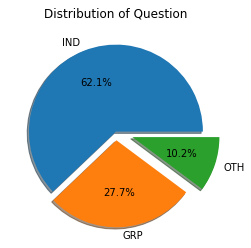

In [9]:
ax=train_data['subtask_c'].value_counts().plot.pie(explode=[0,0.1,0.2],autopct='%1.1f%%' ,shadow=True)
ax.set_title('Distribution of Question')
ax.set_ylabel('')
plt.show()

Individual:  2407
Group :  1074
Other :  395


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


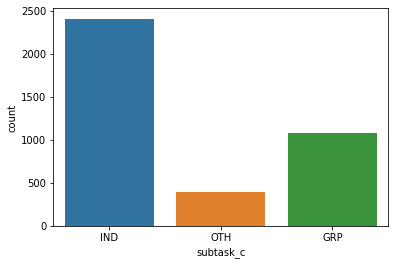

In [10]:
plot_sb = sb.countplot(train_data['subtask_c'], label='Total')
IND, GRP ,OTH  = train_data['subtask_c'].value_counts()
print('Individual: ',IND)
print('Group : ',GRP)
print('Other : ',OTH)

In [11]:
def handle_emoji(text):
    # Dictionnary of "important" emojis : 
    emoji_dict =  {'♥️': ' love ',
                   '❤️' : ' love ',
                   '❤' : ' love ',
                   '😘' : ' kisses ',
                  '😭' : ' cry ',
                  '💪' : ' strong ',
                  '🌍' : ' earth ',
                  '💰' : ' money ',
                  '👍' : ' ok ',
                   '👌' : ' ok ',
                  '😡' : ' angry ',
                  '🍆' : ' dick ',
                  '🤣' : ' haha ',
                  '😂' : ' haha ',
                  '🖕' : ' fuck you '}

    for cha in emoji_dict:
        text = re.compile(str(cha)).sub(str(emoji_dict[cha]),text)
    # Remove ALL emojis
    text = emoji.get_emoji_regexp().sub(r' ',text) 
    text = re.compile("([\U0001f3fb-\U0001f3ff])").sub(r'',text) 
    text = re.compile("([\U00010000-\U0010ffff])").sub(r'',text) 
    text = re.compile("(\u00a9|\u00ae|[\u2000-\u3300]|\ud83c[\ud000-\udfff]|\ud83d[\ud000-\udfff]|\ud83e[\ud000-\udfff])").sub(r'',text)

    # Add Space between  the Emoji Expressions : 
    text = re.compile("([\U00010000-\U0010ffff])").sub(r' \1 ',text) 
    return text

In [12]:
def clean_tweet(text):
    ''' Function that is applied to every to tweet in the dataset '''

    # =========== TEXT ===========
    # Replace @USER by <user>
    text = re.compile(r'@USER').sub(r'<user>',text)

    # Replace URL by <url>
    text = re.compile(r'URL').sub(r'<url>',text)

    # Remove numbers :
    text = re.compile(r'[0-9]+').sub(r' ',text)

    # Remove some special characters
    text = re.compile(r'([\xa0_\{\}\[\]¬•$,:;/@#|\^*%().~`”"“-])').sub(r' ',text) 

    # Space the special characters with white spaces
    text = re.compile(r'([$&+,:;=?@#|\'.^*()%!"’“-])').sub(r' \1 ',text)

    # Replace some special characters : 
    replace_dict = {r'&' : 'and' , r'&amp;' : 'and' , 
                    r'\+' : 'plus'}
    for cha in replace_dict:
        text = re.compile(str(cha)).sub(str(replace_dict[cha]),text)

    # Handle Emoji : translate some and delete the others
    text = handle_emoji(text)

    # Word delengthening : 
    text = re.compile(r'(.)\1{3,}').sub(r'\1\1',text)

    # Cut the words with caps in them : 
    text = re.compile(r'([a-z]+|[A-Z]+|[A-Z][a-z]+)([A-Z][a-z]+)').sub(r'\1 \2',text)
    text = re.compile(r'([a-z]+|[A-Z]+|[A-Z][a-z]+)([A-Z][a-z]+)').sub(r'\1 \2',text)        
    # =========== TOKENS ===========
    # TOKENIZE 
    text = text.split(' ')

    # Remove white spaces tokens
    text = [text[i] for i in range(len(text)) if text[i] != ' ']

    # Remove empty tokens
    text = [text[i] for i in range(len(text)) if text[i] != '']

    # Remove repetition in tokens (!!! => !)
    text = [text[i] for i in range(len(text)) if text[i] != text[i-1]]

    #  Handle the ALL CAPS Tweets 
    ### if ratio of caps in the word > 75% add allcaps tag <allcaps>
    caps_r = np.mean([text[i].isupper() for i in range(len(text))])
    if caps_r > 0.6 : 
        text.append('<allcaps>')

    # Lower Case : 
    text = [text[i].lower() for i in range(len(text))]
    
    return " ".join(str(x) for x in text)

In [13]:
train_data['subtask_c'].replace({'IND':0, 'GRP': 1, 'OTH': 2}, inplace= True)

In [14]:
train_data["preprocessed_tweet"] = train_data["tweet"].apply(clean_tweet)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'


In [15]:
train_data = train_data.dropna(subset=['subtask_c'])
train_data.head()

,tweet,subtask_a,subtask_b,subtask_c,preprocessed_tweet
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,0.0,<user> go home you re drunk ! <user> maga trum...
5,@USER Liberals are all Kookoo !!!,OFF,TIN,2.0,<user> liberals are all kookoo !
7,@USER was literally just talking about this lo...,OFF,TIN,1.0,<user> was literally just talking about this l...
9,@USER Canada doesn’t need another CUCK! We alr...,OFF,TIN,0.0,<user> canada doesn t need another cuck ! we a...
12,@USER you are a lying corrupt traitor!!! Nobod...,OFF,TIN,0.0,<user> you are a lying corrupt traitor ! nobod...


In [16]:
train_data["preprocessed_tweet"].shape

(3876,)

In [17]:
X = train_data["preprocessed_tweet"].values
y = train_data["subtask_c"].values

In [18]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, stratify=y, test_size=0.20)

In [19]:
print("Train shape : ",train_X.shape)
#print("Validation shape : ",val_X.shape)
print("Test shape : ",test_X.shape)

Train shape :  (3100,)
Test shape :  (776,)


In [20]:
unique, counts = np.unique(train_y, return_counts=True)
print(np.asarray((unique, counts)).T)

# unique, counts = np.unique(val_y, return_counts=True)
# print(np.asarray((unique, counts)).T)

unique, counts = np.unique(test_y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[0.000e+00 1.925e+03]
 [1.000e+00 8.590e+02]
 [2.000e+00 3.160e+02]]
[[  0. 482.]
 [  1. 215.]
 [  2.  79.]]


In [21]:
testdf = pd.DataFrame()
testdf['tweet'] = test_X

testdf['subtask_c'] = test_y
testdf.shape

(776, 2)

In [22]:
def tfidf_vectorizer(X, train_X, test_X):
    
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_vectorizer.fit(X)

    train_text_features_tf = tfidf_vectorizer.transform(train_X)
    test_text_features_tf = tfidf_vectorizer.transform(test_X)
    
    return train_text_features_tf, test_text_features_tf

In [23]:
def count_vectorizer(X, train_X, test_X):
    
    count_vectorizer = CountVectorizer()
    count_vectorizer.fit(X)

    train_text_features_cv = count_vectorizer.transform(train_X)
    test_text_features_cv = count_vectorizer.transform(test_X)
    
    return train_text_features_cv, test_text_features_cv

In [24]:
def undersampleData(train_text_features_tf, train_y):
    rus = RandomUnderSampler(random_state=0)
    X_resampled, y_resampled = rus.fit_resample(train_text_features_tf, train_y)
    return X_resampled, y_resampled

In [25]:
def oversampleData(train_text_features_tf, train_y):
    from imblearn.over_sampling import SMOTE
    smote = SMOTE('minority')
    x_oversampled, y_oversampled = smote.fit_sample(train_text_features_tf, train_y)
    return x_oversampled, y_oversampled

In [26]:
def getConfusionMatrix(y_test, y_pred):
  # Confusion matrix
  mat = confusion_matrix(y_test, y_pred)
  cm = pd.DataFrame(mat)
  TP = cm.iloc[1,1] # True Positive
  TN = cm.iloc[0,0] # True Negative
  FP = cm.iloc[0,1] # False Positive
  FN = cm.iloc[1,0] # False Negative

  print('Sensitivity: {:.2%}'.format(TP/(FN+TP)))
  print('Specificity: {:.2%}'.format(TN/(FP+TN)))
  
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
  plt.title('A confusion matrix showing the frequency of misclassifications by our classifier')
  plt.xlabel('true label')
  plt.ylabel('predicted label');
  plt.show()

In [27]:
def model(model, X, train_X, train_y, test_X, test_y, tfidf = True, cv = False, undersampled = False, oversample = False):
    
    if tfidf:
        print('Feature Extraction using TFIFD')
        train_text_features, test_text_features = tfidf_vectorizer(X, train_X, test_X)
    
    if cv:
        print('Feature Extraction using CV')
        train_text_features, test_text_features = count_vectorizer(X, train_X, test_X)

    if undersampled:
        print('Undersampling the dataset')
        train_text_features, train_y = undersampleData(train_text_features, train_y)

    if oversample:
        print('Oversampling the dataset')
        train_text_features, train_y = oversampleData(train_text_features, train_y)
        
    model.fit(train_text_features, train_y)

    # predict the labels on validation dataset
    predictions = model.predict(test_text_features)

    # Use accuracy_score function to get the accuracy
    print("Accuracy Score -> ",accuracy_score(predictions, test_y)*100)

    print('F1Score', f1_score(predictions, test_y, average="macro"))
    print('Precision', precision_score(predictions, test_y, average="weighted"))
    print('Recall', recall_score(predictions, test_y, average="weighted"))

    getConfusionMatrix(test_y, predictions)

Feature Extraction using TFIFD
Undersampling the dataset
Accuracy Score ->  55.154639175257735
F1Score 0.4593913600888752
Precision 0.5301883634381239
Recall 0.5515463917525774
Sensitivity: 86.25%
Specificity: 67.67%


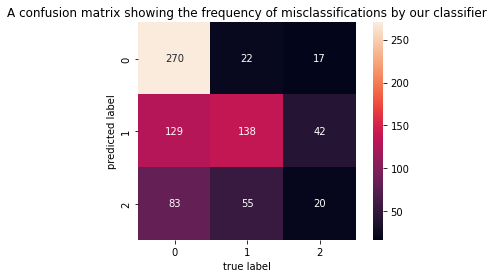

In [28]:
model(naive_bayes.MultinomialNB(), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = True, oversample = False)

Feature Extraction using TFIFD
Undersampling the dataset
Accuracy Score ->  58.634020618556704
F1Score 0.4964097034085256
Precision 0.5455937977452658
Recall 0.586340206185567
Sensitivity: 82.01%
Specificity: 80.94%


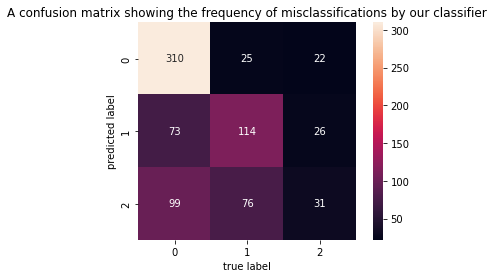

In [29]:
model(svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto'), X, train_X, train_y,
      test_X, test_y, tfidf = True, cv = False, undersampled = True, oversample = False)

Feature Extraction using CV
Undersampling the dataset
Accuracy Score ->  65.4639175257732
F1Score 0.5386107719441052
Precision 0.6274868423304389
Recall 0.654639175257732
Sensitivity: 75.15%
Specificity: 83.41%


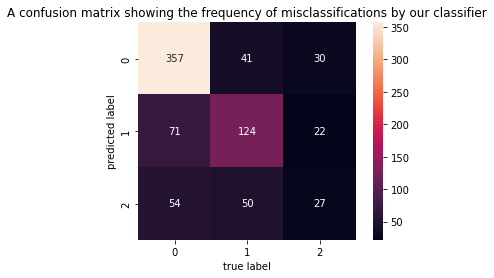

In [30]:
from sklearn.ensemble import RandomForestClassifier

model(RandomForestClassifier(n_estimators=100, max_depth=20,random_state=0), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = True, oversample = False)

Feature Extraction using CV


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy Score ->  71.26288659793815
F1Score 0.5066074590202158
Precision 0.7637059227403972
Recall 0.7126288659793815
Sensitivity: 64.65%
Specificity: 88.98%


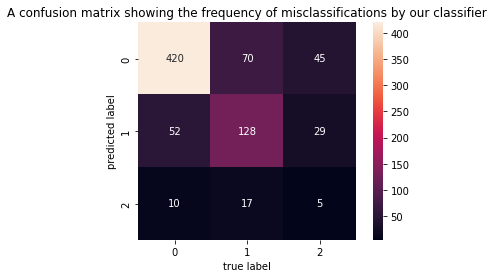

In [31]:
from sklearn.linear_model import LogisticRegression

model(LogisticRegression(), X, train_X, train_y,
      test_X, test_y, tfidf = False, cv = True, undersampled = False, oversample = False)